In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import data_preprocessing as dp
import utilities
import models.training as train


In [2]:
data, events = dp.load_data(subjects=range(1,11))
data, events = dp.choose_condition(data, events, 'inner speech')

### Paramters

In [24]:
train_size = 0.8
test_size = 0.1
valid_size = 0.1
explained_var = 0.98

### Functions:
 - plot original and reconstructed pca data
 - plot PCA
 - Plot difference between original and PCA reconstruction


In [25]:
def side_by_side(original, reconstructed, indexes):
    org = original[indexes]
    rec = reconstructed[indexes]
    middle = np.zeros((org.shape[0],20))
    pair = np.concatenate((org, middle), axis=1)
    pair = np.concatenate((pair, rec), axis=1)
    plt.figure(figsize=(16,14))
    plt.imshow(pair, cmap='viridis')
    plt.title('Before and after pca')
    plt.show()

In [26]:
def pca_pic(pca_data, index, dim = 1):
    plt.figure(figsize= (8 ,6))
    if dim != 1:
        plt.imshow(pca_data[index])
    else:
        plt.plot(pca_data)
    plt.title('PCA data')
    plt.show()

In [27]:
def difference(original, reconstructed, indexes):
    org = original[indexes]
    rec = reconstructed[indexes]
    diff = org-rec
    plt.figure(figsize=(8,7))
    plt.imshow(diff)
    plt.title('Difference: Before- after')
    plt.show()

### Data preparation:
filter relevant interval


In [28]:
f_data = dp.filter_interval(data, [1,3.5],256)

Standardize

In [29]:
#standardize data
scaler = StandardScaler()
s_data = scaler.fit_transform(f_data.reshape(-1, f_data.shape[-1])).reshape(f_data.shape)

### Create PCA datasets

In [30]:
# reshape version
rf_data = s_data.reshape(len(s_data), 128*640)
# mean version
mean_data = np.mean(s_data, axis = 0)

### Fit and apply PCA:
Fit and apply on reshaped data

Shape before PCA:  (2076, 81920)
Shape after PCA:  (2076, 1603)


Text(0.5, 1.0, 'PCA on reshaped EEG data')

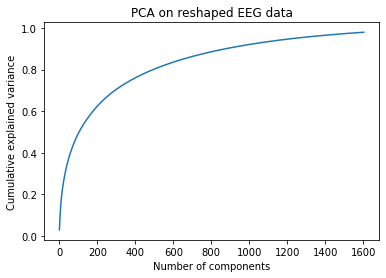

In [31]:
# fit and apply on reshaped data
pca_1 = PCA(n_components=explained_var)
rf_pca = pca_1.fit_transform(rf_data)

# print shapes before and after pca
print("Shape before PCA: ", rf_data.shape)
print("Shape after PCA: ", rf_pca.shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA on reshaped EEG data")

In [32]:
# reverse pca
inv_rf_pca = pca_1.inverse_transform(rf_pca)
inv_rf = [scaler.inverse_transform(elem.reshape(128, 640)) for elem in inv_rf_pca]

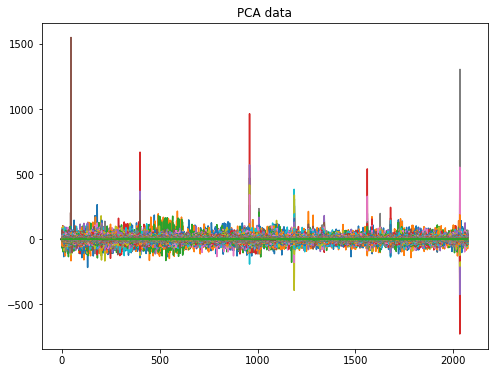

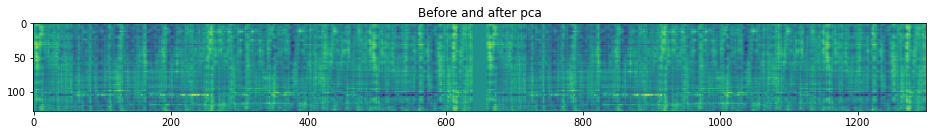

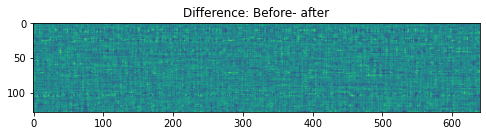

In [33]:
# plot results
for elem in range(1):
    pca_pic(rf_pca, elem)
    side_by_side(f_data, inv_rf,elem)
    difference(f_data, inv_rf,elem)

fit on mean data, applied on time dimension

Shape before PCA:  (128, 640)
Shape after PCA:  (128, 35)


Text(0.5, 1.0, 'PCA based on mean EEG data for time dimension')

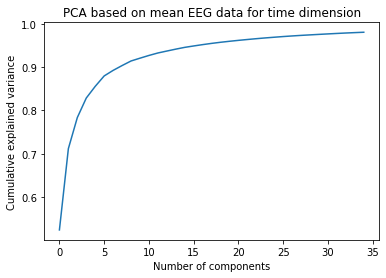

In [34]:
# fit on mean data, applied on time dimension
pca_2 = PCA(n_components=explained_var)
pca_2.fit(mean_data)
mean_time_pca = [pca_2.transform(elem) for elem in s_data]

# print shapes before and after pca
print("Shape before PCA: ", mean_data.shape)
print("Shape after PCA: ", mean_time_pca[0].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA based on mean EEG data for time dimension")

In [35]:
# reverse pca
inv_mean_time_pca = [pca_2.inverse_transform(elem) for elem in mean_time_pca]
inv_mean_time= [scaler.inverse_transform(elem) for elem in inv_mean_time_pca]

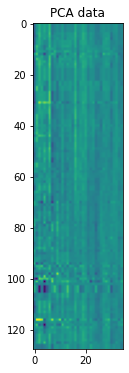

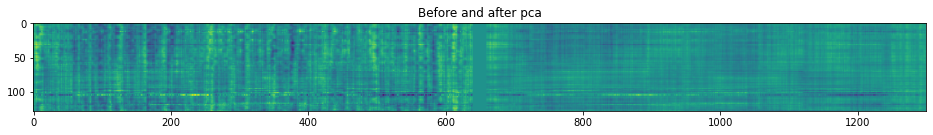

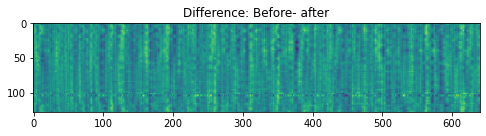

In [36]:
# plot results
for elem in range(1):
    pca_pic(mean_time_pca, elem, dim = 2)
    side_by_side(f_data, inv_mean_time,elem)
    difference(f_data, inv_mean_time,elem)

fit on transposed mean data, applied on channel dimension

Shape before PCA:  (128, 640)
Shape after PCA:  (44, 640)


Text(0.5, 1.0, 'PCA on reshaped EEG data for channel dimension')

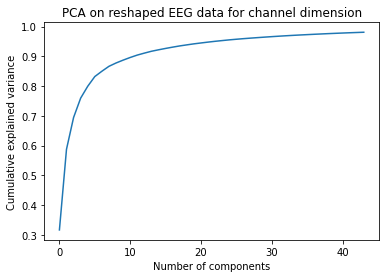

In [37]:
# fit on transposed mean data, applied on channel dimension
pca_3 = PCA(n_components=explained_var)
pca_3.fit(mean_data.T)
mean_channel_pca = [pca_3.transform(elem.T).T for elem in s_data]

# print shapes before and after pca
print("Shape before PCA: ", mean_data.shape)
print("Shape after PCA: ", mean_channel_pca[0].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA on reshaped EEG data for channel dimension")

In [38]:
# reverse pca
inv_mean_channel_pca = [pca_3.inverse_transform(elem.T).T for elem in mean_channel_pca]
inv_mean_channel= [scaler.inverse_transform(elem) for elem in inv_mean_channel_pca]

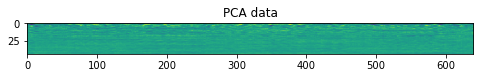

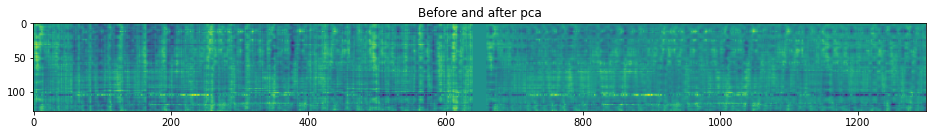

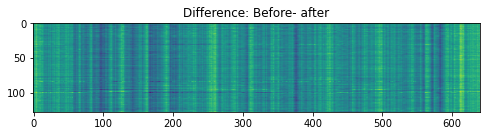

In [39]:
# plot results
for elem in range(1):
    pca_pic(mean_channel_pca, elem, dim = 2)
    side_by_side(f_data, inv_mean_channel,elem)
    difference(f_data, inv_mean_channel,elem)

### Create Tensorflow dataset

In [40]:
pca_comp = rf_pca.shape[1]


In [41]:
rf_dataset = tf.data.Dataset.from_tensor_slices((rf_pca, events[:, 1]))
rf_dataset = dp.preprocessing_pipeline(
    rf_dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 lambda sample: (tf.reshape(sample[0], (pca_comp, 1, 1)),
                                 sample[1])],
    args = [[], []],
    batch_size = 12
)
rf_datasets = dp.split_dataset(rf_dataset)


In [42]:
time_dataset = tf.data.Dataset.from_tensor_slices((mean_time_pca, events[:, 1]))
time_dataset = dp.preprocessing_pipeline(
    time_dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                lambda sample: (tf.reshape(sample[0],(*sample[0].shape, 1)), sample[1])],
    args = [[], []],
    batch_size = 12
)
time_datasets = dp.split_dataset(time_dataset)


In [43]:
channel_dataset = tf.data.Dataset.from_tensor_slices((mean_channel_pca, events[:, 1]))
channel_dataset = dp.preprocessing_pipeline(
    channel_dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                lambda sample: (tf.reshape(sample[0],(*sample[0].shape, 1)), sample[1])],
    args = [[], []],
    batch_size = 12
)
channel_datasets = dp.split_dataset(channel_dataset)


In [47]:
for elem in channel_dataset.take(1):
    print(elem)

(<tf.Tensor: shape=(12, 44, 640, 1), dtype=float64, numpy=
array([[[[ 3.56288689],
         [ 0.49758258],
         [-0.76215719],
         ...,
         [ 0.07250217],
         [ 1.04733376],
         [-0.0171269 ]],

        [[ 3.43358415],
         [ 5.19601425],
         [ 5.75360227],
         ...,
         [-2.32050276],
         [-1.70228089],
         [-1.36025596]],

        [[-0.79788039],
         [-0.29460599],
         [ 0.08208599],
         ...,
         [-2.11570918],
         [-2.60331479],
         [-1.42112054]],

        ...,

        [[-0.72202997],
         [-0.10051716],
         [-0.51631218],
         ...,
         [ 1.39134966],
         [ 1.24890129],
         [ 1.97086901]],

        [[ 1.59911375],
         [ 1.68342687],
         [ 1.98498129],
         ...,
         [ 0.1391249 ],
         [-0.12563846],
         [-0.4860128 ]],

        [[ 0.04992489],
         [ 0.1184627 ],
         [ 0.12788184],
         ...,
         [ 0.01760683],
         [-0.1523

### save datasets

In [44]:
# save dataset so that we can just load the preprocessed version next time
tf.data.experimental.save(rf_dataset, 'dataset/preprocessed/reshaped_pca98_ds')
tf.data.experimental.save(time_dataset, 'dataset/preprocessed/time_pca98_ds')
tf.data.experimental.save(channel_dataset, 'dataset/preprocessed/channel_pca98_ds')